# Import SQLite database from Kaggle
---

In [1]:
!pip install eralchemy

In [2]:
import eralchemy
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lennykiruthu","key":"d94060f80a6b492d1ec1026f9f8b13dc"}'}

In [3]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d lennykiruthu/linkedin-jobs-sqlite --unzip -p ./data

Dataset URL: https://www.kaggle.com/datasets/lennykiruthu/linkedin-jobs-sqlite
License(s): CC-BY-SA-4.0
 73% 117M/161M [00:00<00:00, 596MB/s] 
100% 161M/161M [00:00<00:00, 440MB/s]


The following table are in our database: [('companies',), ('skills',), ('industries',), ('positions',), ('company_industries',), ('company_specialities',), ('employee_count',), ('job_skills',), ('job_industries',)]


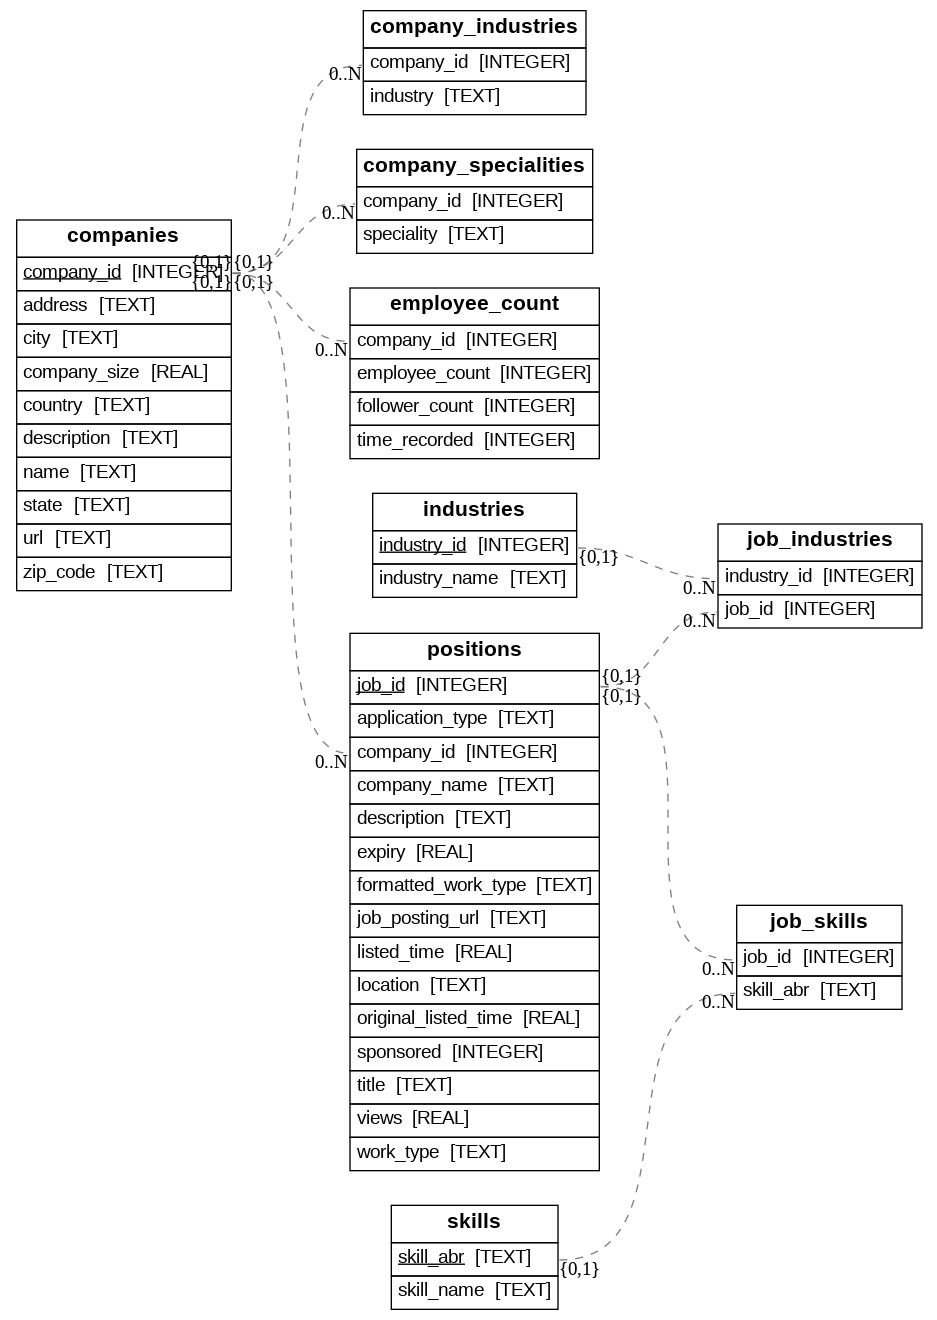

In [5]:
import sqlite3
import pandas as pd
from IPython.display import Image

conn = sqlite3.connect('./data/linkedin_jobs.db')
cur  = conn.cursor()

cur.execute("SELECT name FROM  sqlite_master WHERE type='table'")
print(f"The following table are in our database: {cur.fetchall()}")

!cp /content/data/linkedin_jobs.db /content/data/tmp_linkedin_jobs.db
!eralchemy -i sqlite:////content/data/tmp_linkedin_jobs.db -o /content/data/linkedin_jobs_erd.dot
!dot -Tpng /content/data/linkedin_jobs_erd.dot -o /content/data/linkedin_jobs_erd.png
Image(filename='/content/data/linkedin_jobs_erd.png')

# Exploratory Data Analaysis
---

In [6]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
positions_df            = pd.read_sql("SELECT * FROM positions;", conn)
companies_df            = pd.read_sql("SELECT * FROM companies;", conn)
skills_df               = pd.read_sql("SELECT * FROM skills;", conn)
industries_df           = pd.read_sql("SELECT * FROM industries;", conn)
company_industries_df   = pd.read_sql("SELECT * FROM company_industries;", conn)
company_specialities_df = pd.read_sql("SELECT * FROM company_specialities;", conn)
employee_count_df       = pd.read_sql("SELECT * FROM employee_count;", conn)
job_skills_df           = pd.read_sql("SELECT * FROM job_skills;", conn)
job_industries_df       = pd.read_sql("SELECT * FROM job_industries;", conn)

In [8]:
def explore(title, df):
  display(Markdown(title))
  display(df.head(10))
  display(Markdown('## Descriptive Statistics'))
  display(df.describe())
  display(Markdown('## Missing Values'))
  display(df.isnull().sum().sort_values(ascending=False))
  display(Markdown('## Data Types'))
  display(df.dtypes)
  display(Markdown('## Shape'))
  display(df.shape)

# explore("# Positions Dataframe", positions_df)

In [9]:
# df_columns = [col for col in job_skills_df.columns]

# for i, col in enumerate(df_columns):
#   display(job_skills_df[col].head(10))

In [10]:
!pip install -q sentence-transformers

In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import re
import spacy

In [12]:
titles = positions_df['title'].fillna("").tolist()
print(titles)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
nlp = spacy.load("en_core_web_sm")

titles_emb = model.encode(
    titles,
    batch_size=256,
    show_progress_bar=True,
    normalize_embeddings=True  # makes cosine similarity easier
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

In [14]:
k = 200
km_titles = KMeans(n_clusters=k, n_init="auto", random_state=42)
title_labels = km_titles.fit_predict(titles_emb)

positions_df['cluster_id'] = title_labels

In [15]:
cluster_name_map = {}
for i in range(k):
    cluster_indices = np.where(title_labels == i)[0]
    centroid = km_titles.cluster_centers_[i]
    distances = np.linalg.norm(titles_emb[cluster_indices] - centroid, axis=1)
    nearest_idx = cluster_indices[np.argmin(distances)]
    cluster_name_map[i] = titles[nearest_idx]

positions_df['cluster_name'] = positions_df['cluster_id'].map(cluster_name_map)

In [16]:
def clean_text(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    return text

positions_df['clean_desc'] = positions_df['description'].apply(clean_text)

In [20]:
cluster_terms_map = {}

for cluster_id in positions_df['cluster_id'].unique():
    # All descriptions in this cluster
    cluster_texts = positions_df[positions_df['cluster_id'] == cluster_id]['clean_desc'].tolist()

    candidate_phrases = []

    # Process each description individually to avoid memory overload
    for desc in cluster_texts:
        doc = nlp(desc)
        # Extract noun phrases (skills) and verb-containing sentences (responsibilities)
        candidate_phrases.extend([chunk.text for chunk in doc.noun_chunks])
        candidate_phrases.extend([sent.text for sent in doc.sents if any(token.pos_ == "VERB" for token in sent)])

    # Deduplicate phrases
    candidate_phrases = list(set(candidate_phrases))

    # Encode candidate phrases
    phrase_emb = model.encode(candidate_phrases, batch_size=64, show_progress_bar=False, normalize_embeddings=True)

    # Compute cluster embedding (mean of description embeddings)
    cluster_desc_emb = model.encode(cluster_texts, batch_size=256, show_progress_bar=False, normalize_embeddings=True)
    cluster_embedding = np.mean(cluster_desc_emb, axis=0, keepdims=True)

    # Cosine similarity between candidate phrases and cluster embedding
    sim_scores = cosine_similarity(phrase_emb, cluster_embedding).flatten()

    # Select top 15 phrases closest to cluster meaning
    top_indices = sim_scores.argsort()[-15:][::-1]
    top_phrases = [candidate_phrases[i] for i in top_indices]

    cluster_terms_map[cluster_id] = top_phrases

# Map back to DataFrame
positions_df['cluster_terms_semantic'] = positions_df['cluster_id'].map(cluster_terms_map)


KeyboardInterrupt: 

In [ ]:
positions_df[['title', 'cluster_id', 'cluster_name', 'cluster_terms_semantic']].head()

In [ ]:
positions_df['cluster_name'].unique()

In [ ]:
data_analyst = positions_df[['title', 'cluster_id', 'cluster_name', 'cluster_terms_semantic']].query("cluster_name.str.contains('Associate Banker')")

In [ ]:
data_analyst['cluster_terms_semantic'].iloc[0]

In [ ]:
positions_df.to_csv("linkedin_jobs_clustered_skills.csv", index=False)